# Exam 1, Julia Course 2023

## Load Packages and printmat

In [1]:
using Printf, Dates, Statistics, JLD2, Plots
include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

## Load Data and Calculate Returns

from the jld2 file Fx5min.jld2. You want the `dN` (vector of julia DateTimes, eg `2020-01-01T00:05:00`) and `USD_EUR` (vector with the exchange rate: the number of USD you pay for 1 EUR). The data are 5 minute data so there are 288 elements per day for each day 2000-2022. There are 315,648 observations.

Calculate a vector of log returns, that is `log(price/price 5 minute earlier)`.

In [2]:
(USD_EUR, dN) = load("./Fx5min/Fx5min.jld2", "USD_EUR", "dN")

log_returns = [log(USD_EUR[i+1] / USD_EUR[i]) for i in 1:length(USD_EUR)-1]
# Add 0 as first element so they are the same length (can't calculater return for first element), i hope this is allowed
log_returns = prepend!(log_returns, 0)

315648-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.00024078871798240478
 -0.00024078871798251255
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

# Estimate the Std for each Hour

Extract all data points that refer to a time between 00:00 (midnight) and 00:59 (just before 1 o'clock in the night). Estimate the standard deviation of the returns. Repeat for 01:00 and 01:59, etc. Plot the results (multiplied by `10_000`.) with the hour on the horizontal axis. (Hint: `hour(a DateTime) == 0`.

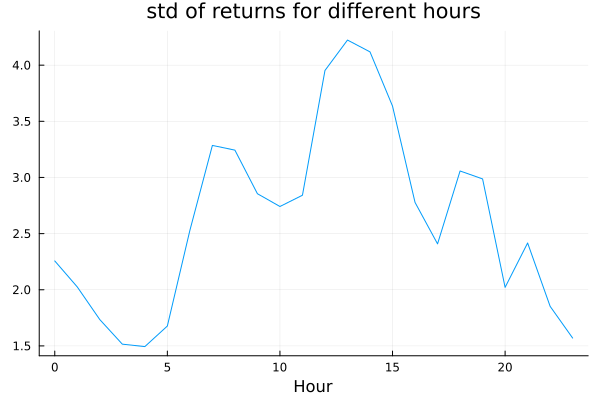

In [3]:
std_devs = zeros(Float64,24)
for h in 0:23
    hourly_data = filter(i -> hour(dN[i]) == h, 1:length(dN))
    returns = [log(USD_EUR[i+1] / USD_EUR[i]) for i in hourly_data if i < length(USD_EUR)]
    std_dev = std(returns) * 10_000
    std_devs[h+1] = std_dev
end
plot(0:23, std_devs, xlabel="Hour", legend=false, title="std of returns for different hours")

# Estimate Autoregressions for each Day of Data

Consider the regression

$r_t = a + b r_{t-1} + \epsilon_t$,

where $r_t$ is a 5-minute return and $r_{t-1}$ is the previous 5-minute return.

Extract data for day 1, estimate the regression and save the estimate of $b$. Redo for day 2, etc.  (Hint:`unique(Date.(vector of DateTimes)).` It's OK if the regressor $r_{t-1}$ includes the observation from 23:55 the day before.  

Create a moving average over `b` for the current and previous 5 days. Plot the `b` estimates against dates (on the horizonztal axis) as well as the moving average (in the same plot) 

In [4]:

# I guess we are using return now instead of log return?
returns = [ (USD_EUR[i+1] - USD_EUR[i]) / USD_EUR[i] for i in 1:length(USD_EUR)-1]
returns = prepend!(returns, 0) # Just make return for first element 0

unique_dates = sort(unique(Date.(dN)))  # I hope this sortes the dates correctly

betas = zeros(Float64, length(unique_dates))
for (index_date, current_date) in enumerate(unique_dates)
    #We include day -1 23:55 to be able to predict the first element of the day as well
    indices_current_day = findall(dt -> Date(dt) == current_date || (Date(dt) == current_date - Day(1) && hour(dt) == 23 && minute(dt) == 55), dN)
    day_returns = returns[indices_current_day]
    rt = day_returns[2:end]
    rt_minus1 = day_returns[1:end-1]

    sxy = sum((rt .- mean(rt)) .* (rt_minus1 .- mean(rt_minus1)))
    sxx = sum((rt_minus1 .- mean(rt_minus1)) .^ 2)

    # a bit hacky but is was 0 sometimes
    if sxx == 0
        sxx = 1e-10
    end
    beta_day = sxy / sxx
    betas[index_date] = beta_day
end
moving_avg_betas = [mean(betas[max(1, i-5+1):i]) for i in 1:length(betas)]


1096

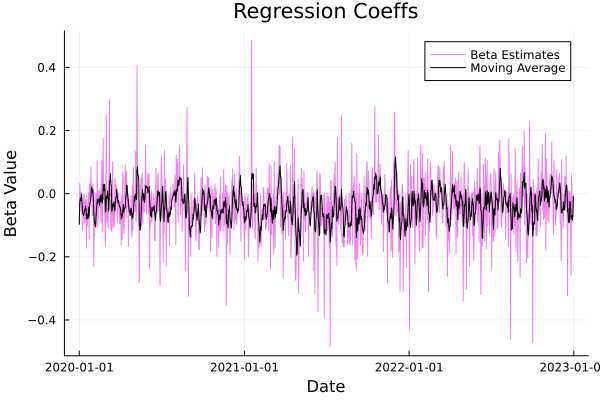

In [47]:
plot(title="Regression Coeffs", xlabel="Date", ylabel="Beta Value", legend=:topright)
plot!(unique_dates, betas, label="Beta Estimates", color=:violet, linewidth=1)
plot!(unique_dates, moving_avg_betas, label="Moving Average", color=:black, linewidth=1)


# Plot a Histogram of the `b` Estimates

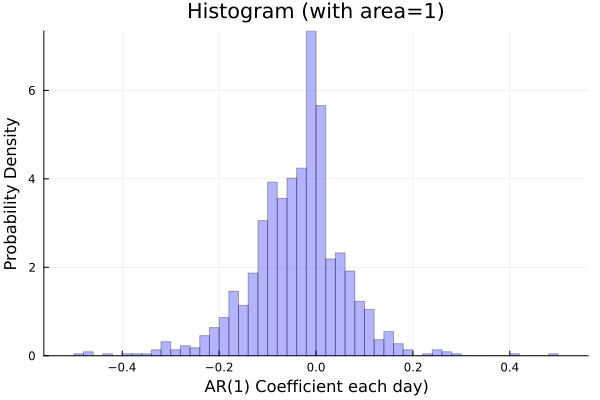

In [46]:
histogram(betas, normed=true, color=:blue, alpha=0.3, legend=false)
xlabel!("AR(1) Coefficient each day)")
ylabel!("Probability Density")
title!("Histogram (with area=1)")